In [742]:
import os, sys, re, datetime, shutil, copy
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.table import Table

In [743]:
# User-defined global parameters

X_CO_H2 = 3e-4
X_CI_CO = 0.2

#global_list_of_T_kin = np.arange(12., 202., 2.) * u.K
global_list_of_T_kin = np.arange(6., 202., 1.) * u.K

#global_list_of_Sigma_H2 = np.array([140., 300., 1000., 1500.]) # 
#global_list_of_CO_abundance = np.array([1e-4, 3e-4, 3e-4, 3e-4])
#global_list_of_RNCINCO = np.array([0.1, 0.1, 0.2, 1.0])
#global_list_of_N_CO = global_list_of_Sigma_H2 * global_list_of_CO_abundance / \
#                      1.60141791e-20 # from Sigma_H2 (no helium) to N_CO
#global_list_of_N_CI = global_list_of_N_CO * global_list_of_RNCINCO # 0.2 times of N_CO
#global_list_of_N_CO = global_list_of_Sigma_H2 * X_CO_H2 / 1.60141791e-20 # from Sigma_H2 (no helium) to N_CO
#global_list_of_N_CI = global_list_of_N_CO * X_CI_CO # 0.2 times of N_CO
#global_list_of_d_V_for_N_species = [5., 15., 30., 90.]
#global_list_of_linecolor_for_N_species = ['blue', 'orange', 'purple', 'red']
#global_list_of_linestyle_for_N_species = ['dashdot', 'solid', 'dashed', 
#                                          {'loosely dashed': (0, (5, 10))}, 
#                                          {'dotted': (0, (1, 1))} ]

#global_list_of_N_CO = np.array([9.78e17, 2.63e18, 5.81e18, 
#                                1.64e19, 6.37e18, 2.64e19]) # see 'calc_LTE_R_CI10CO21.ipynb'
global_list_of_N_CO = np.array([7.917038739797097e+17, 2.1451966625873075e+18, 4.782717218184588e+18, 
                                1.124846592151412e+19, 5.668637345904719e+18, 1.2512312063200076e+19,
                               ]) # see 'calc_LTE_R_CI10CO21.ipynb'
global_list_of_N_CI = global_list_of_N_CO * X_CI_CO # 0.2 times of N_CO
global_list_of_d_V_for_N_species = [4., 10., 20., 
                                    60., 50., 90.]
import matplotlib
from matplotlib import cm
norm = matplotlib.colors.Normalize(vmin=18.05, vmax=19.35, 
                                   clip=True) # vmin=17.0+0.3, vmax=20.0-0.4, see 'calc_LTE_R_CI10CO21.ipynb'
cmap = cm.gist_rainbow_r
colormapper = cm.ScalarMappable(norm=norm, cmap=cmap)
global_list_of_linecolor_for_N_species = ['blue', 'purple', 'green', 'gold', 
                                          'orange', 'red', ] 
                                         # [colormapper.to_rgba(np.log10(t)) for t in global_list_of_N_CO]
global_list_of_linestyle_for_N_species = ['dashdot', 'solid', 'dashed', 
                                          'dotted', 
                                          {'loosely dashed': (0, (5, 10))}, 
                                          {'dotted': (0, (1, 1))} ]
global_list_of_linethick_for_N_species = [2.0, 2.0, 2.0, 
                                          1.5, 1.5, 1.5]
global_list_of_linelabel_for_N_species = [None, None, None, 
                                          None, None, None]

# global_list_of_Sigma_H2 values are for
#   Solomon87 Galactic molecular clouds (I_CO > 40 - 60 K km s-1)
#   NGC3627 disk giant molecular clouds (I_CO ~ 50 - 100 K km s-1), 
#   NGC3627 bar end massive star forming regions (I_CO ~ 350-450Kkms), 
#   NGC3627 center, 


In [744]:
CO = {}
CO['Einstein_A'] = np.array([
    7.203e-08, 6.910e-07, 2.497e-06, 6.126e-06, 1.221e-05, 2.137e-05, 3.422e-05, 5.134e-05, 7.330e-05, 1.006e-04, 
    1.339e-04, 1.735e-04, 2.200e-04, 2.739e-04, 3.354e-04, 4.050e-04, 4.829e-04, 5.695e-04, 6.650e-04, 7.695e-04, 
    8.833e-04, 1.006e-03, 1.139e-03, 1.281e-03, 1.432e-03, 1.592e-03, 1.761e-03, 1.940e-03, 2.126e-03, 2.321e-03, 
    2.524e-03, 2.735e-03, 2.952e-03, 3.175e-03, 3.404e-03, 3.638e-03, 3.878e-03, 4.120e-03, 4.365e-03, 4.613e-03, 
])
CO['E_u'] = np.array([
    5.53,      16.60,   33.19,   55.32,   82.97,  116.16,  154.87,  199.11,  248.88, 304.16, 
    364.97,   431.29,  503.13,  580.49,  663.35,  751.72,  845.59,  944.97, 1049.84, 1160.20, 
    1276.05, 1397.38, 1524.19, 1656.47, 1794.23, 1937.44, 2086.12, 2240.24, 2399.82, 2564.83, 
    2735.28, 2911.15, 3092.45, 3279.15, 3471.27, 3668.78, 3871.69, 4079.98, 4293.64, 4512.67, 
])
CO['nu'] = np.array([
     115.2712018,  230.5380000,  345.7959899,  461.0407682,  576.2679305, 
     691.4730763,  806.6518060,  921.7997000, 1036.9123930, 1151.9854520, 
    1267.0144860, 1381.9951050, 1496.9229090, 1611.7935180, 1726.6025057, 
    1841.3455060, 1956.0181390, 2070.6159930, 2185.1346800, 2299.5698420, 
    2413.9171130, 2528.1720600, 2642.3303459, 2756.3875840, 2870.3394070, 
    2984.1814550, 3097.9093610, 3211.5187506, 3325.0052827, 3438.3646110, 
    3551.5923610, 3664.6841800, 3777.6357280, 3890.4427170, 4003.1007876, 
    4115.6055850, 4227.9527744, 4340.1381120, 4452.1571221, 4564.0056399, 
])

In [745]:
CI = {}
CI['Einstein_A'] = np.array([
    7.880E-08, 2.650E-07, 
    #1.810E-14, 
])
CI['E_u'] = np.array([
    23.620, 62.462, 
    # 62.462, 
])
CI['nu'] = np.array([
    492.160651, 809.34197, 
    # 1301.50262, 
])

In [746]:
def calc_Q(E_u, T_kin, N=None):
    E_j = np.concatenate([[0.0], E_u])
    if N is None:
        N = len(E_j)
    j = np.arange(N)
    E_j = E_j[0:N]
    #E_j = (j*(j+1)) * E_u[0]
    return np.sum(1.0 * (j+(j+1)) * np.exp(-1.0 * E_j / T_kin))

In [747]:
def calc_Bnu(
        nu, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    Bnu = 2*h*(nu*1e9)**3/c**2 * (1.0 / (np.exp(hnu_kt) - 1.0))
    return Bnu

def calc_Bnu_CI10(T_ex):
    global CI
    j_u = 1
    j_l = 0
    idx_trans = 0
    return calc_Bnu(
        nu = CI['nu'][idx_trans], 
        T_ex = T_ex, 
    )

def calc_Bnu_CO21(T_ex):
    global CO
    j_u = 2
    j_l = 1
    idx_trans = 1
    return calc_Bnu(
        nu = CO['nu'][idx_trans], 
        T_ex = T_ex, 
    )

def calc_tau(
        nu, 
        g_u, 
        Q, 
        A_ul, 
        N_dV, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    #print('nu', nu)
    #print('Q', Q)
    #print('c**3/(8.0*pi*(nu*1e9)**3)', c**3/(8.0*pi*(nu*1e9)**3))
    #print('hnu_kt', hnu_kt)
    N_dV_cm_2_km_s_1 = N_dV # input should have a unit of cm^{-2} (km s^{-1})^{-1}
    N_dV_cm_2_cm_s_1 = N_dV_cm_2_km_s_1 / 1e5 # km^{-1} to cm^{-1}
    return c**3/(8.0*pi*(nu*1e9)**3) * (g_u/Q) * A_ul * N_dV_cm_2_cm_s_1 / 1.0645 * (1.0 - np.exp( -hnu_kt ))

# def calc_tau_CI10(N_dV, T_ex):
#     global CI
#     j_u = 1
#     j_l = 0
#     idx_trans = 0
#     return calc_tau(
#         nu = CI['nu'][idx_trans], 
#         g_u = 2*j_u+1, 
#         Q = calc_Q(CI['E_u'], T_ex), 
#         A_ul = CI['Einstein_A'][idx_trans],
#         N_dV = N_dV, 
#         T_ex = T_ex, 
#     )

# def calc_tau_CO21(N_dV, T_ex):
#     global CO
#     j_u = 2
#     j_l = 1
#     idx_trans = 1
#     return calc_tau(
#         nu = CO['nu'][idx_trans], 
#         g_u = 2*j_u+1, 
#         Q = calc_Q(CO['E_u'], T_ex), 
#         A_ul = CO['Einstein_A'][idx_trans],
#         N_dV = N_dV, 
#         T_ex = T_ex, 
#     )


### Prepare function to plot the Q-E term

In [748]:
# define function to plot one set of Q*ehnukt*Bnuratio vs. T_kin

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 11.5
matplotlib.rcParams['ytick.labelsize'] = 11.5
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['axes.formatter.useoffset'] = False
#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.cal'] = 'stix:italic'
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
import matplotlib.patheffects as path_effects

def make_a_plot_for_Q_E_term_vs_T_kin(
        x, 
        Q, 
        nu,
        z=0.0, 
        species='CO', 
        kfactor=None, 
        top_left_text=None, 
        out_fig_name=None, 
        return_kfactor=False,
    ):
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_xlabel('T_kin / [K]', fontsize=13, labelpad=3)
    ax1.set_ylabel(r'$Coefficients \ (as \ labelled)$', fontsize=13.5, labelpad=12)
    
    # Computing coefficients to be shown in panels 1-3
    hnuk = const.h.cgs * nu.cgs / const.k_B.cgs
    ehnukt = np.exp(hnuk / x)
    ehnuktcmb = np.exp(hnuk / (2.73*u.K * (1.0+z)))
    Bnuratio = 1.0 / ( 1.0 - ( (ehnukt-1.0) / (ehnuktcmb-1.0) ) )
    y1 = Q * ehnukt * Bnuratio
    y2 = Q
    y3 = ehnukt * Bnuratio
    
    # Panel 1
    ax1.plot(x, y1, 
             color='C0', lw=2, alpha=0.9, 
             label=r'Coeff.: $ Q \; \mathrm{e}^{%.2f / T_{\mathrm{kin}}} \; / \; '%(hnuk.value) + 
                   r'\left[ 1 - ( \mathrm{e}^{%.2f / T_{\mathrm{kin}}} -1 ) \, / \, '%(hnuk.value) + 
                   r'( \mathrm{e}^{%.2f / T_{\mathrm{CMB}}} - 1 ) \right] }$'%(hnuk.value), 
             )
    ax1.set_xlim(ax1.get_xlim())
    
    # Top left text in Panel 1
    if top_left_text is not None:
        if z > 0.0:
            top_left_text = copy.copy(top_left_text)
            top_left_text += r' $z = %g$'%(z)
        tt1 = ax1.text(0.02, 0.96, top_left_text, fontsize=14, ha='left', va='top', transform=ax1.transAxes)
        tt1.set_path_effects([path_effects.Stroke(linewidth=0.6, foreground='black'), path_effects.Normal()])
    
    # Panel 2
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_xlabel('T_kin / [K]', fontsize=13)
    ax2.plot(x, y2, 
             color='C2', lw=2, alpha=0.9, 
             label=r'Coeff.: $Q$', 
            )
    ax2.set_xlim(ax2.get_xlim())
    
    # Panel 3
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_xlabel('T_kin / [K]', fontsize=13)
    #ax3.set_ylabel(r'$\mathrm{e}^{h \nu/{(k_{\mathrm{B}} T_{\mathrm{kin}})}}$')
    ax3.plot(x, y3, 
             color='C1', lw=2, alpha=0.9, 
             label=r'Coeff.: $\mathrm{e}^{%.2f / T_{\mathrm{kin}}} \; / \; '%(hnuk.value) + 
                   r'\left[ 1 - ( \mathrm{e}^{%.2f / T_{\mathrm{kin}}} -1 ) \, / \, '%(hnuk.value) + 
                   r'( \mathrm{e}^{%.2f / T_{\mathrm{CMB}}} - 1 ) \right] }$'%(hnuk.value), 
            )
    ax3.set_xlim(ax3.get_xlim())
    ax3.plot(ax3.get_xlim(), [1.0, 1.0], ls='dashed', lw=1.2, color='k', alpha=0.8, label='$y = 1.0$')
    
    # Overplot function lines in Panels
    if species == 'CO':
        ax1.set_ylim([0.0, ax1.get_ylim()[1]*1.05])
        # show the 2 T / E_1 function
        global CO
        E_1 = CO['E_u'][0]
        # fit the kfactor / normalization factor
        if kfactor is None:
            kmask = np.logical_and(x.cgs.value>=20.0, 
                                   x.cgs.value<=100.0) # use T_kin 20 - 100 K to compute the normalization factor
            kfactor = np.mean(y1[kmask].value - (2.0 * x[kmask].cgs.value / E_1))
            print('kfactor', kfactor)
        print('alphaCO function coefficients', kfactor)
        # z=0. CO10 kfactor=2.78
        # z=4. CO10 kfactor=8.08
        overplot_func1a = lambda t: 2.0 * t / E_1 # 2 T / E_1
        overplot_func1b = lambda t: 2.0 * t / E_1 + kfactor # 2 T / E_1 + kfactor
        ax1.plot(ax1.get_xlim(), overplot_func1a(np.array(ax1.get_xlim())), 
                 ls='dashed', lw=1.2, color='k', alpha=0.8, 
                 label=r'$y = 2 \, T_{\mathrm{kin}} \, / \, %s$'%(
                     E_1))
        ax1.plot(ax1.get_xlim(), overplot_func1b(np.array(ax1.get_xlim())), 
                 ls='dotted', lw=3, color='magenta', alpha=0.8, zorder=99, 
                 label=r'$y = 2 \, T_{\mathrm{kin}} \, / \, %.2f \, + \, %.2f \ \, ({\it fitted})$'%(
                     E_1, kfactor))
        ax2.plot(ax2.get_xlim(), overplot_func1a(np.array(ax2.get_xlim())), 
                 ls='dashed', lw=1.2, color='k', alpha=0.8, 
                 label=r'$y = 2 \, T_{\mathrm{kin}} \, / \, %.2f$'%(
                     E_1))
        # print max diff
        #print('max diff (y1-yfit)/y1:', list(zip(x.cgs.value, 
        #      (y1.value-overplot_func1b(x.cgs.value)).value/y1.value)))
        fity1 = overplot_func1b(x.cgs.value) * y1.unit
        diffy1 = (y1-fity1)/y1
        max_positive_diff_indices = np.argmax(diffy1).ravel()[0]
        max_negative_diff_indices = np.argmin(diffy1).ravel()[0]
        print('max diff x, y, (y-yfit)/y:', 
              x[max_positive_diff_indices], ',', 
              y1[max_positive_diff_indices], ',', 
              diffy1[max_positive_diff_indices])
        print('max diff x, y, (y-yfit)/y:', 
              x[max_negative_diff_indices], ',', 
              y1[max_negative_diff_indices], ',', 
              diffy1[max_negative_diff_indices])
    # 
    elif species == 'CI':
        ax1.set_ylim([0.0, ax1.get_ylim()[1]*1.50])
        # show the y range where T_ex = 20 and 100
        #overplot_ylow = np.interp(20.0, x.value, y1)
        #overplot_yhigh = np.interp(100.0, x.value, y1)
        interp_y1 = np.interp(np.arange(20., 100.+2., 2.), x.value, y1)
        overplot_ylow = np.min(interp_y1)
        overplot_yhigh = np.max(interp_y1)
        if kfactor is None:
            kfactor = (overplot_ylow + overplot_yhigh)/2.0
            print('kfactor', kfactor)
        print('alphaCI function coefficients', kfactor, ' = mean of', 
              overplot_ylow, '-', overplot_yhigh, 'over T_kin = 20 - 100 K')
        ax1.fill_between(ax1.get_xlim(), 
                         [overplot_ylow, overplot_ylow], 
                         [overplot_yhigh, overplot_yhigh], 
                         lw=0, color='magenta', alpha=0.2, 
                         label=r'$y = %.1f - %.1f \ \, (T_{\mathrm{kin}} = 20 - 100 \; \mathrm{K})$'%(
                             overplot_ylow, overplot_yhigh))
        fity1 = y1*0.0 + kfactor
        diffy1 = (y1-fity1)/y1
        max_positive_diff_indices = np.argmax(diffy1).ravel()[0]
        max_negative_diff_indices = np.argmin(diffy1).ravel()[0]
        print('max diff x, y, (y-yfit)/y:', 
              x[max_positive_diff_indices], ',', 
              y1[max_positive_diff_indices], ',', 
              diffy1[max_positive_diff_indices])
        print('max diff x, y, (y-yfit)/y:', 
              x[max_negative_diff_indices], ',', 
              y1[max_negative_diff_indices], ',', 
              diffy1[max_negative_diff_indices])
    
    # Adjust panel axes
    ax1.legend(fontsize=13, bbox_to_anchor=(0.0, 1.0, 1.0, 0.2), loc='lower center')
    ax1.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(25.))
    
    ax2.legend(fontsize=13, bbox_to_anchor=(0.0, 1.0, 1.0, 0.2), loc='lower center')
    ax2.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(25.))
    
    ax3.legend(fontsize=13, bbox_to_anchor=(0.0, 1.0, 1.0, 0.2), loc='lower center')
    ax3.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
    ax3.xaxis.set_major_locator(ticker.MultipleLocator(25.))
    
    fig.tight_layout()
    
    if out_fig_name is not None:
        if z > 0.0:
            out_fig_name = copy.copy(out_fig_name)
            out_fig_name += '_z%g'%(z)
        fig.savefig(out_fig_name+'.pdf', dpi=300)
        print('Output to "%s"'%(out_fig_name+'.pdf'))
    
    if return_kfactor:
        return fig, kfactor
    else:
        return fig


### Now we plot the Q-T term

T_CMB 2.73 K
coe1 258.2537558492139 1 / (cm3 K)
coe2 1195121272.845638 s / (cm3 K)
coe3 1.915452546725204e-06 s solMass / (K km pc2)
coe4 0.6384841822417346 s solMass / (K km pc2)
alphaCO10 function coefficients
list_of_T_kin [  6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.
  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158

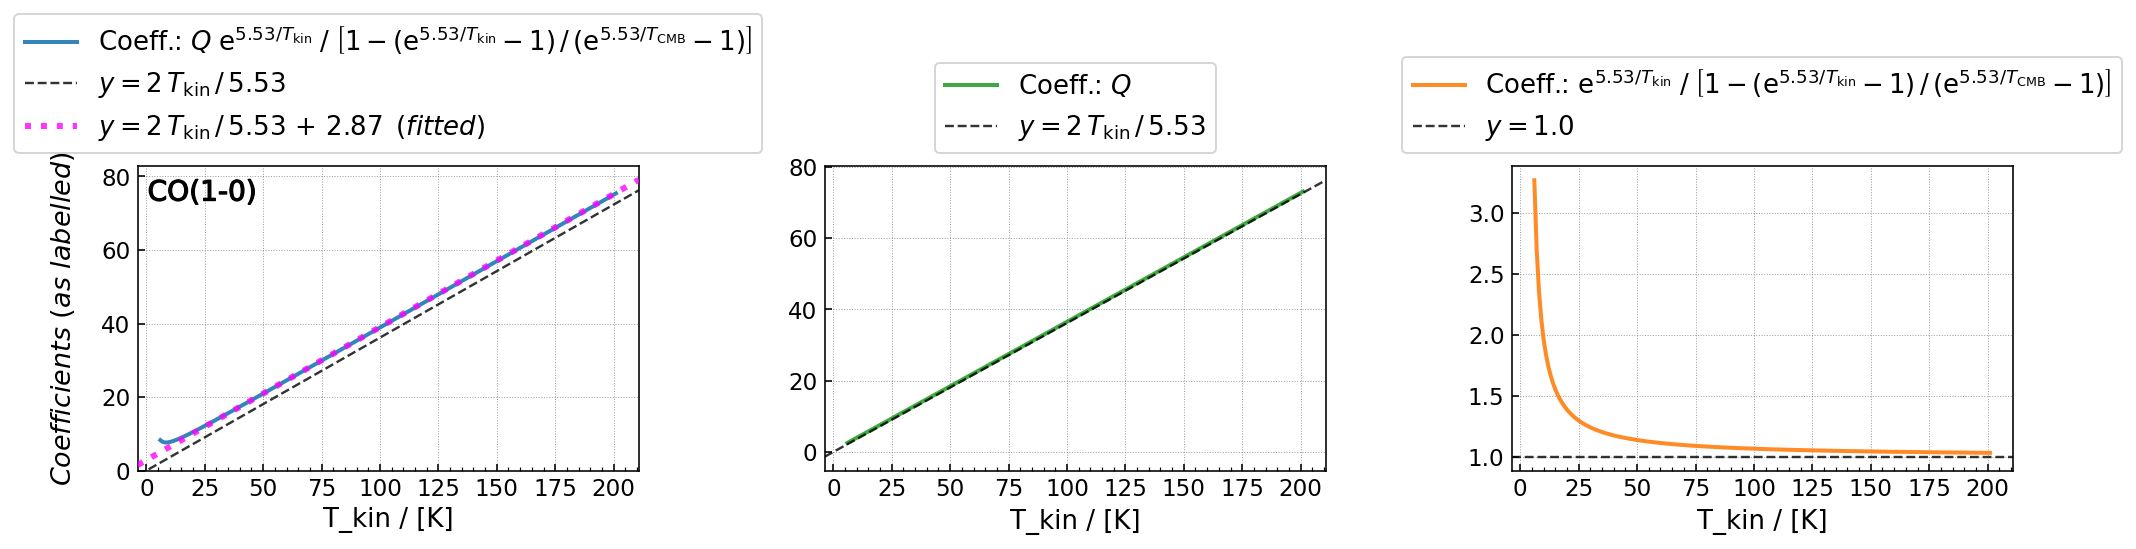

In [749]:
# CO10
z = 0. # 0. 4. 10.
nu = CO['nu'][0] * u.GHz
A_ul = CO['Einstein_A'][0] * u.s**(-1) # 1-0 is the first transition
j_u = 1 # 1-0
g_u = 2*j_u + 1
T_CMB = 2.73 * (1.0 + z) * u.K
E_1 = CO['E_u'][0] # always 1-0 upper level, do not set a unit here

print('T_CMB', T_CMB)

# 8 pi kB nu^2 / ( h c^3 )
coe1 = 8 * np.pi * const.k_B.cgs * nu.cgs**2 / (const.h.cgs * const.c.cgs**3)
print('coe1', coe1)

# 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul
coe2 = coe1 / g_u / A_ul
print('coe2', coe2)

# 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
coe3 = (coe2 * (const.m_p + const.m_e).cgs*2).to(u.M_sun * u.pc**(-2) * u.K**(-1) * u.km**(-1) * u.s)
print('coe3', coe3)

# X_CO^{-1} * 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul * 100 [M_sun pc-2 (K km s-1)-1]
X_CO = X_CO_H2 # [CO/H2]
coe4 = X_CO**(-1) * coe3 * 100
print('coe4', coe4)
print('alphaCO10 function coefficients')

# 
#list_of_T_kin = np.arange(20., 200., 2.) * u.K
#list_of_T_kin = np.arange(8., 152., 2.) * u.K
list_of_T_kin = copy.copy(global_list_of_T_kin)
if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
    list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
print('list_of_T_kin', list_of_T_kin)
Q = np.array([ calc_Q(CO['E_u'], T_kin.value) for T_kin in list_of_T_kin ])
ehnukt = np.array([ np.exp(const.h.cgs * nu.cgs / (const.k_B.cgs * T_kin)) for T_kin in list_of_T_kin ])
Bnuratio = np.array([ calc_Bnu(nu.to(u.GHz).value, T_kin.value) / ( \
        calc_Bnu(nu.to(u.GHz).value, T_kin.value) - calc_Bnu(nu.to(u.GHz).value, T_CMB.value) \
    ) for T_kin in list_of_T_kin ])

top_left_text = 'CO(1-0)'
out_fig_name = 'Plot_LTE_alpha_CO10'
fig, kfactor = make_a_plot_for_Q_E_term_vs_T_kin(list_of_T_kin, Q, nu, z=z, species='CO', 
                                                 top_left_text=top_left_text, 
                                                 out_fig_name=out_fig_name, 
                                                 return_kfactor=True)

CO10_coe4 = coe4
CO10_kfactor = kfactor


T_CMB 2.73 K
coe1 1032.9755604482543 1 / (cm3 K)
coe2 298979901.72163653 s / (cm3 K)
coe3 4.791830144641124e-07 s solMass / (K km pc2)
coe4 0.1597276714880375 s solMass / (K km pc2)
alphaCO21 function coefficients
list_of_T_kin [  6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.
  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 1

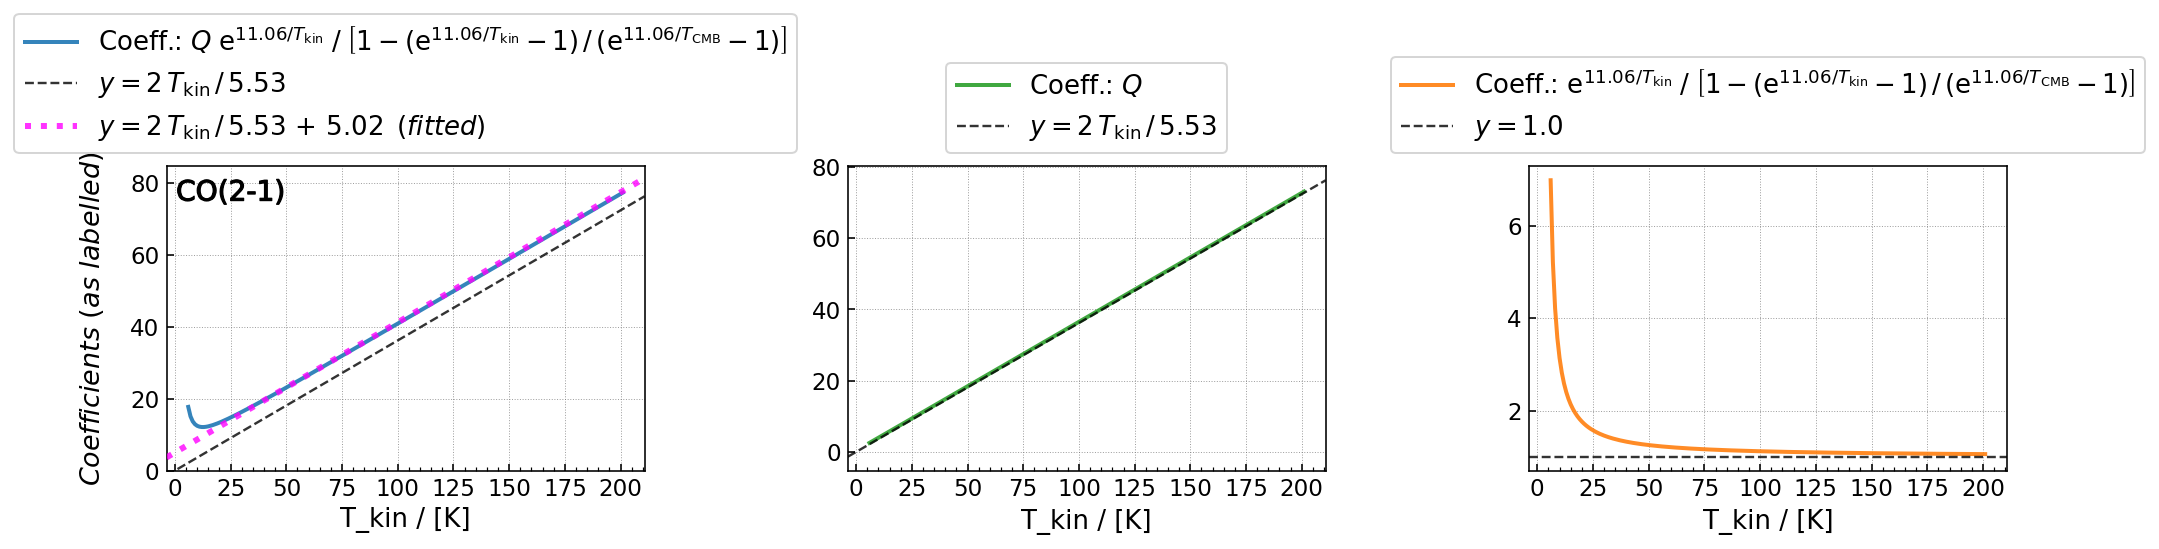

In [750]:
# CO21
z = 0. # 4.
nu = CO['nu'][1] * u.GHz # 2-1 is the second transition
A_ul = CO['Einstein_A'][1] * u.s**(-1) # 2-1 is the second transition
j_u = 2 # 2-1
g_u = 2*j_u + 1
T_CMB = 2.73 * (1.0 + z) * u.K
E_1 = CO['E_u'][0] # always 1-0 upper level 

print('T_CMB', T_CMB)

# 8 pi kB nu^2 / ( h c^3 )
coe1 = 8 * np.pi * const.k_B.cgs * nu.cgs**2 / (const.h.cgs * const.c.cgs**3)
print('coe1', coe1)

# 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul
coe2 = coe1 / g_u / A_ul
print('coe2', coe2)

# 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
coe3 = (coe2 * (const.m_p + const.m_e).cgs*2).to(u.M_sun * u.pc**(-2) * u.K**(-1) * u.km**(-1) * u.s)
print('coe3', coe3)

# X_CO^{-1} * 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul * 100 [M_sun pc-2 (K km s-1)-1]
X_CO = X_CO_H2 # [CO/H2]
coe4 = X_CO**(-1) * coe3 * 100
print('coe4', coe4)
print('alphaCO21 function coefficients')

# 
#list_of_T_kin = np.arange(20., 200., 2.) * u.K
#list_of_T_kin = np.arange(8., 152., 2.) * u.K
list_of_T_kin = copy.copy(global_list_of_T_kin)
if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
    list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
print('list_of_T_kin', list_of_T_kin)
Q = np.array([ calc_Q(CO['E_u'], T_kin.value) for T_kin in list_of_T_kin ])
ehnukt = np.array([ np.exp(const.h.cgs * nu.cgs / (const.k_B.cgs * T_kin)) for T_kin in list_of_T_kin ])
Bnuratio = np.array([ calc_Bnu(nu.to(u.GHz).value, T_kin.value) / ( \
        calc_Bnu(nu.to(u.GHz).value, T_kin.value) - calc_Bnu(nu.to(u.GHz).value, T_CMB.value) \
    ) for T_kin in list_of_T_kin ])

top_left_text = 'CO(2-1)'
out_fig_name = 'Plot_LTE_alpha_CO21'
fig, kfactor = make_a_plot_for_Q_E_term_vs_T_kin(list_of_T_kin, Q, nu, z=z, species='CO', 
                                                 top_left_text=top_left_text, 
                                                 out_fig_name=out_fig_name, 
                                                 return_kfactor=True)

CO21_coe4 = coe4
CO21_kfactor = kfactor


T_CMB 2.73 K
coe1 4707.808412686791 1 / (cm3 K)
coe2 19914587194.10656 s / (cm3 K)
coe3 3.19176368328768e-05 s solMass / (K km pc2)
coe4 0.5319606138812801 s solMass / (K km pc2)
alphaCI10 function coefficients
list_of_T_kin [  6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.
  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158.

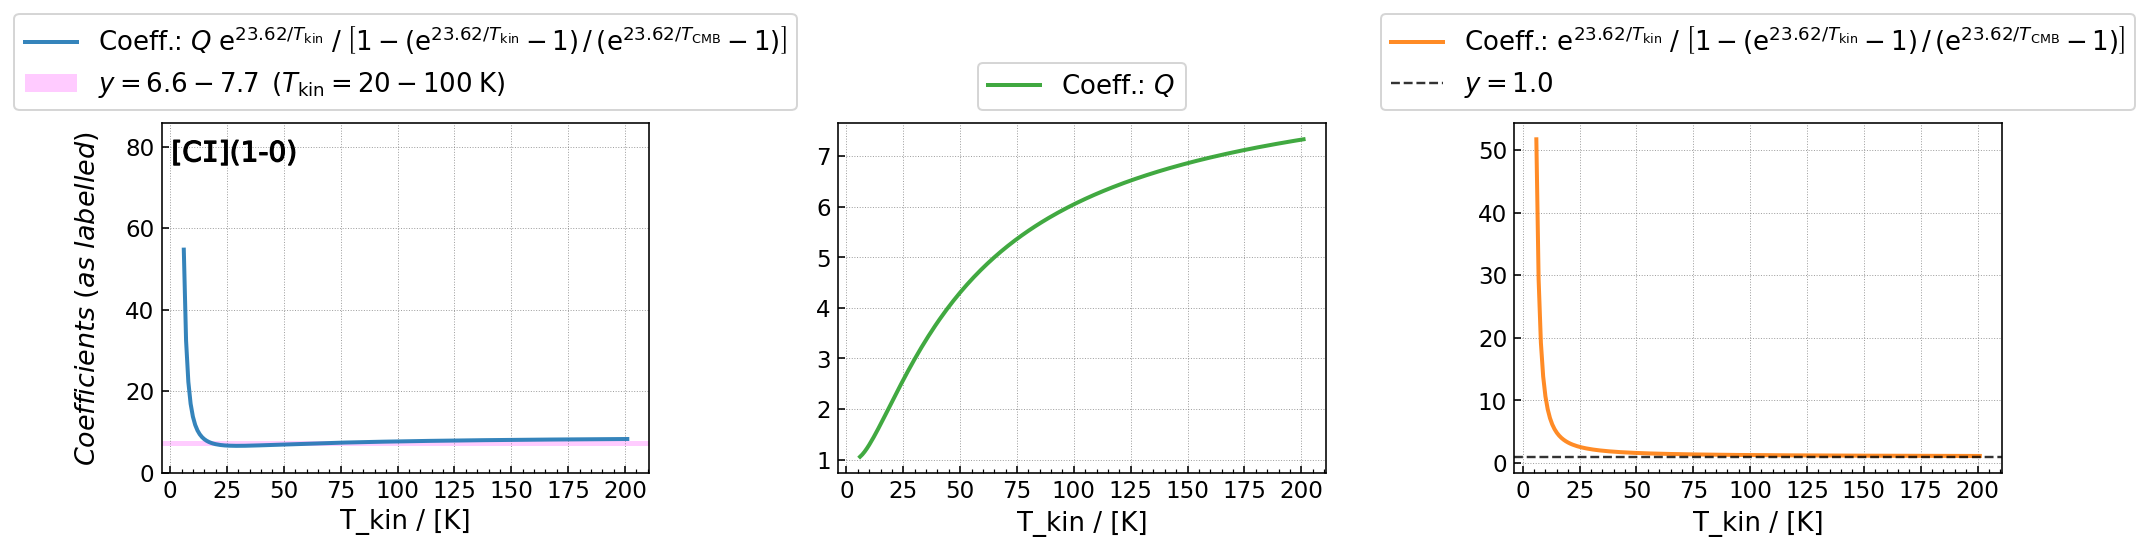

In [751]:
# CI10
z = 0. # 4.
nu = CI['nu'][0] * u.GHz # 1-0 is the first transition
A_ul = CI['Einstein_A'][0] * u.s**(-1) # 1-0 is the first transition
j_u = 1 # 1-0
g_u = 2*j_u + 1
T_CMB = 2.73 * (1.0 + z) * u.K
E_1 = CI['E_u'][0] # always 1-0 upper level 

print('T_CMB', T_CMB)

# 8 pi kB nu^2 / ( h c^3 )
coe1 = 8 * np.pi * const.k_B.cgs * nu.cgs**2 / (const.h.cgs * const.c.cgs**3)
print('coe1', coe1)

# 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul
coe2 = coe1 / g_u / A_ul
print('coe2', coe2)

# 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
coe3 = (coe2 * (const.m_p + const.m_e).cgs*2).to(u.M_sun * u.pc**(-2) * u.K**(-1) * u.km**(-1) * u.s)
print('coe3', coe3)

# X_CI^{-1} * 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
X_CI = X_CO_H2 * X_CI_CO # [CI/H2]
coe4 = X_CI**(-1) * coe3
print('coe4', coe4)
print('alphaCI10 function coefficients')

# 
#list_of_T_kin = np.arange(20., 200., 2.) * u.K
#list_of_T_kin = np.arange(8., 152., 2.) * u.K
list_of_T_kin = copy.copy(global_list_of_T_kin)
if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
    list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
print('list_of_T_kin', list_of_T_kin)
Q = np.array([ calc_Q(CI['E_u'], T_kin.value) for T_kin in list_of_T_kin ])
#ehnukt = np.array([ np.exp(const.h.cgs * nu.cgs / (const.k_B.cgs * T_kin)) for T_kin in list_of_T_kin ])
#Bnuratio = np.array([ calc_Bnu(nu.to(u.GHz).value, T_kin.value) / ( 
# calc_Bnu(nu.to(u.GHz).value, T_kin.value) - calc_Bnu(nu.to(u.GHz).value, T_CMB.value) 
# ) for T_kin in list_of_T_kin ])

top_left_text = r'[C$\tt{I}$](1-0)'
out_fig_name = 'Plot_LTE_alpha_CI10'
fig, kfactor = make_a_plot_for_Q_E_term_vs_T_kin(list_of_T_kin, Q, nu, z=z, species='CI', 
                                                 top_left_text=top_left_text, 
                                                 out_fig_name=out_fig_name, 
                                                 return_kfactor=True)

CI10_coe4 = coe4
CI10_kfactor = kfactor


T_CMB 2.73 K
coe1 12731.193778019833 1 / (cm3 K)
coe2 9608448134.354591 s / (cm3 K)
coe3 1.5399714545457403e-05 s solMass / (K km pc2)
coe4 0.2566619090909567 s solMass / (K km pc2)
alphaCI21 function coefficients
list_of_T_kin [  6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.
  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 1

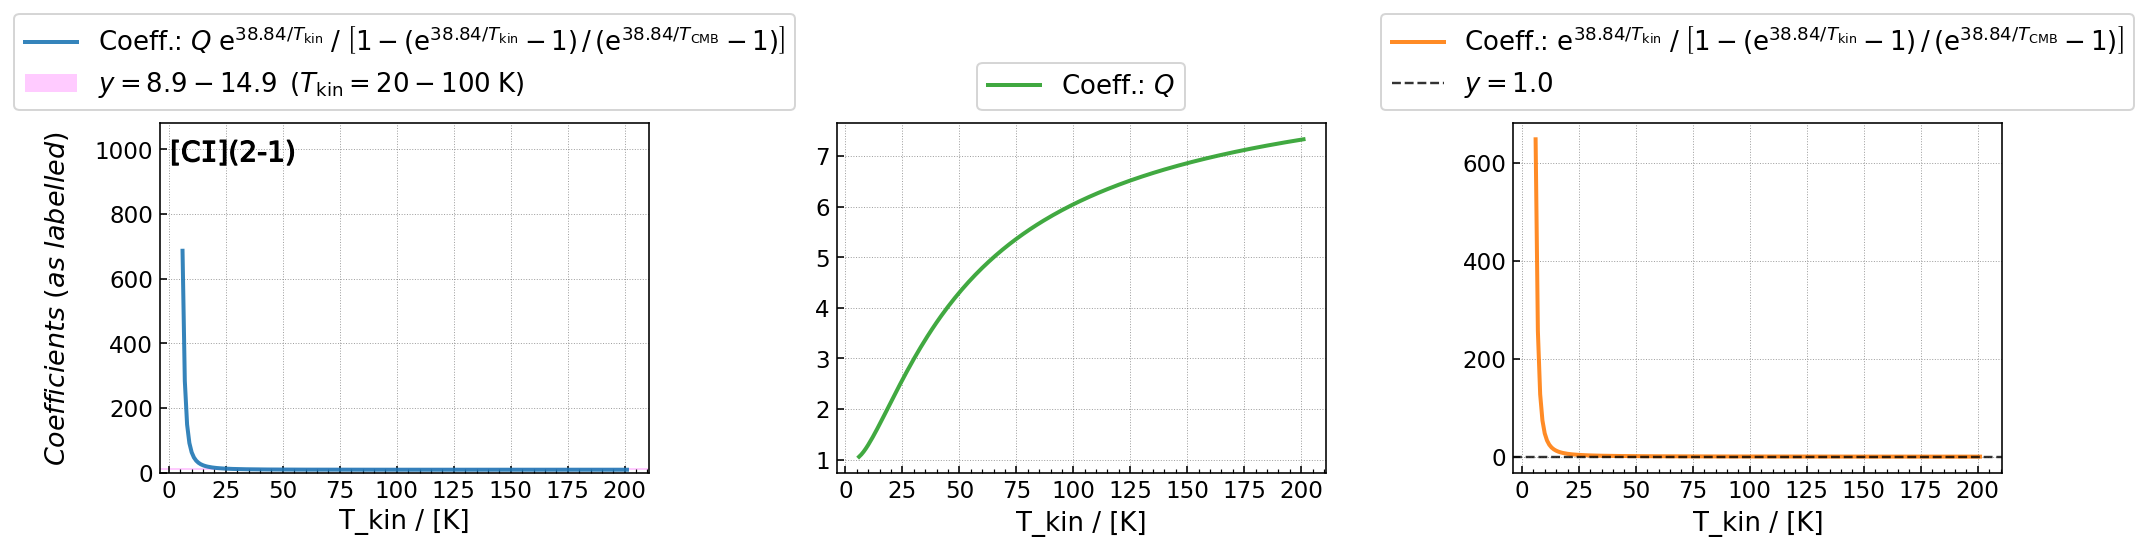

In [752]:
# CI21
z = 0. # 4.
nu = CI['nu'][1] * u.GHz # 2-1 is the second transition
A_ul = CI['Einstein_A'][1] * u.s**(-1) # 2-1 is the second transition
j_u = 2 # 2-1
g_u = 2*j_u + 1
T_CMB = 2.73 * (1.0 + z) * u.K
E_1 = CI['E_u'][0] # always 1-0 upper level 

print('T_CMB', T_CMB)

# 8 pi kB nu^2 / ( h c^3 )
coe1 = 8 * np.pi * const.k_B.cgs * nu.cgs**2 / (const.h.cgs * const.c.cgs**3)
print('coe1', coe1)

# 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul
coe2 = coe1 / g_u / A_ul
print('coe2', coe2)

# 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
coe3 = (coe2 * (const.m_p + const.m_e).cgs*2).to(u.M_sun * u.pc**(-2) * u.K**(-1) * u.km**(-1) * u.s)
print('coe3', coe3)

# X_CI^{-1} * 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
X_CI = X_CO_H2 * X_CI_CO # [CI/H2]
coe4 = X_CI**(-1) * coe3
print('coe4', coe4)
print('alphaCI21 function coefficients')

# 
#list_of_T_kin = np.arange(20., 200., 2.) * u.K
#list_of_T_kin = np.arange(8., 152., 2.) * u.K
list_of_T_kin = copy.copy(global_list_of_T_kin)
if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
    list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
print('list_of_T_kin', list_of_T_kin)
Q = np.array([ calc_Q(CI['E_u'], T_kin.value) for T_kin in list_of_T_kin ])
ehnukt = np.array([ np.exp(const.h.cgs * nu.cgs / (const.k_B.cgs * T_kin)) for T_kin in list_of_T_kin ])
Bnuratio = np.array([ calc_Bnu(nu.to(u.GHz).value, T_kin.value) / ( \
        calc_Bnu(nu.to(u.GHz).value, T_kin.value) - calc_Bnu(nu.to(u.GHz).value, T_CMB.value) \
    ) for T_kin in list_of_T_kin ])

top_left_text = r'[C$\tt{I}$](2-1)'
out_fig_name = 'Plot_LTE_alpha_CI21'
fig, kfactor = make_a_plot_for_Q_E_term_vs_T_kin(list_of_T_kin, Q, nu, z=z, species='CI', 
                                                 top_left_text=top_left_text, 
                                                 out_fig_name=out_fig_name, 
                                                 return_kfactor=True)

CI21_coe4 = coe4
CI21_kfactor = kfactor


In [753]:
print('CO10_coe4', '=', CO10_coe4.value, '#', CO10_coe4.unit)
print('CO10_kfactor', '=', CO10_kfactor)
print('CO21_coe4', '=', CO21_coe4.value, '#', CO21_coe4.unit)
print('CO21_kfactor', '=', CO21_kfactor)
print('CI10_coe4', '=', CI10_coe4.value, '#', CI10_coe4.unit)
print('CI10_kfactor', '=', CI10_kfactor)
print('CI21_coe4', '=', CI21_coe4.value, '#', CI21_coe4.unit)
print('CI21_kfactor', '=', CI21_kfactor)


CO10_coe4 = 0.6384841822417346 # s solMass / (K km pc2)
CO10_kfactor = 2.865695748367211
CO21_coe4 = 0.1597276714880375 # s solMass / (K km pc2)
CO21_kfactor = 5.017088565910618
CI10_coe4 = 0.5319606138812801 # s solMass / (K km pc2)
CI10_kfactor = 7.113087782520815
CI21_coe4 = 0.2566619090909567 # s solMass / (K km pc2)
CI21_kfactor = 11.923220661563994


### Define function to plot the tau term

In [760]:
# define function to plot one set of Q*ehnukt*Bnuratio vs. T_kin

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 11.5
matplotlib.rcParams['ytick.labelsize'] = 11.5
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['axes.formatter.useoffset'] = False
#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.cal'] = 'stix:italic'
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
import matplotlib.patheffects as path_effects

def make_a_plot_for_tau_term_vs_T_kin(
        list_of_T_kin=None, 
        z=0.0, 
        species='CO', 
        transition=0, 
        j_u=1, 
        d_V=None, 
        species_to_H2_conversion=None,
        top_left_text=None, 
        first_panel_text=None,
        first_panel_approx=None, 
        second_panel_approx=None, 
        third_panel_approx=None, 
        out_fig_name=None, 
    ):
    
    global global_list_of_T_kin
    global global_list_of_N_CO
    global global_list_of_N_CI
    global global_list_of_d_V_for_N_species
    global global_list_of_linestyle_for_N_species
    global global_list_of_linecolor_for_N_species
    global global_list_of_linelabel_for_N_species
    global global_list_of_linethick_for_N_species
    global X_CO_H2
    global X_CI_CO
    
    T_CMB = 2.73 * (1.0 + z) # u.K
    
    if list_of_T_kin is None:
        #list_of_T_kin = np.arange(20., 200., 2.) # u.K
        #list_of_T_kin = np.arange(8., 152., 2.) # u.K
        list_of_T_kin = (copy.copy(global_list_of_T_kin)).value
    if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
        list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
    print('list_of_T_kin', list_of_T_kin)
    
    list_of_N_species_linestyle = global_list_of_linestyle_for_N_species # ['dashdot','solid','dashed','dotted']
    list_of_N_species_linecolor = global_list_of_linecolor_for_N_species # ['blue', 'orange', 'purple', 'red']
    list_of_N_species_linethick = global_list_of_linethick_for_N_species # [2.0, 2.0, 2.0, 1.5]
    list_of_N_species_linelabel = global_list_of_linelabel_for_N_species
    list_of_d_V_for_N_species = global_list_of_d_V_for_N_species
    
    if species == 'CO':
        list_of_N_species = copy.copy(global_list_of_N_CO)
        list_of_Sigma_H2 = np.array(list_of_N_species).astype(float) / \
                           X_CO_H2 * 1.60141791e-20 # from N_CO to Sigma_H2 (no helium)
        print('list_of_N_species', list_of_N_species)
        print('list_of_Sigma_H2', list_of_Sigma_H2)
        print('list_of_d_V_for_N_species', list_of_d_V_for_N_species)
        global CO
        species_moldata = CO
    elif species == 'CI':
        list_of_N_species = copy.copy(global_list_of_N_CI)
        list_of_Sigma_H2 = np.array(list_of_N_species).astype(float) / \
                           (X_CO_H2 * X_CI_CO) * 1.60141791e-20
        print('list_of_N_species', list_of_N_species)
        print('list_of_Sigma_H2', list_of_Sigma_H2)
        print('list_of_d_V_for_N_species', list_of_d_V_for_N_species)
        global CI
        species_moldata = CI
    else:
        raise Exception('Error! The input species must be either "CO" or "CI"!')
    
    if d_V is not None:
        if np.isscalar(d_V):
            list_of_d_V_for_N_species = [d_V]*len(list_of_d_V_for_N_species)
        else:
            list_of_d_V_for_N_species = d_V
        print('list_of_d_V_for_N_species', list_of_d_V_for_N_species)
    
    list_of_tau_dict = {}
    for idx_N_species, N_species in enumerate(list_of_N_species):
        N_species = float(N_species)
        N_species_str = re.sub(r'e\+(0+|)', r'e', '%.1e'%(N_species))
        #print('N_species', N_species)
        d_V = list_of_d_V_for_N_species[idx_N_species]
        d_V_str = '%.1f'%(d_V)
        #print('d_V', d_V)
        N_dV = N_species / d_V
        #print('N_dV', N_dV)
        list_of_tau = np.array([
            calc_tau(
                nu = species_moldata['nu'][transition], 
                g_u = 2*j_u+1, 
                Q = calc_Q(species_moldata['E_u'], T_ex), 
                A_ul = species_moldata['Einstein_A'][transition],
                N_dV = N_dV, 
                T_ex = T_ex, 
            ) for T_ex in list_of_T_kin 
        ])
        list_of_tau_dict['N_%s_%s_dV_%s'%(species, N_species_str, d_V_str)] = copy.copy(list_of_tau)
        #print('list_of_tau_dict[\'N_%s_%s_dV_%s\']'%(species, N_species_str, d_V_str), 
        #list_of_tau_dict['N_%s_%s_dV_%s'%(species, N_species_str, d_V_str)])

    #print("list_of_tau_dict['N_CO_5e18']", list_of_tau_dict['N_CO_5e18'])

    fig = plt.figure(figsize=(17,4.8))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    for idx_N_species, N_species in enumerate(list_of_N_species):
        N_species = float(N_species)
        N_species_str = re.sub(r'e\+(0+|)', r'e', '%.1e'%(N_species))
        d_V = list_of_d_V_for_N_species[idx_N_species]
        d_V_str = '%.1f'%(d_V)
        N_d_V = N_species / d_V
        N_d_V_str = re.sub(r'e\+(0+|)', r'e', '%.1e'%(N_d_V))
        list_of_tau = list_of_tau_dict['N_%s_%s_dV_%s'%(species, N_species_str, d_V_str)]
        linestyle = list_of_N_species_linestyle[idx_N_species]
        linethick = list_of_N_species_linethick[idx_N_species]
        linecolor = list_of_N_species_linecolor[idx_N_species]
        linelabel = list_of_N_species_linelabel[idx_N_species]
        Sigma_H2 = list_of_Sigma_H2[idx_N_species]
        Sigma_H2_str = '%.0f'%(Sigma_H2)
        if linelabel is None or linelabel == '':
            linelabel = r'$N_{\mathrm{%s}}$=%s'%(species, N_species_str) + \
                        r', $\Sigma_{\mathrm{H_2}}$=%s'%(Sigma_H2_str) + \
                        r', $\Delta v$=%g'%(d_V) + \
                        '\n' + r'$N_{\mathrm{%s}}/{\Delta v} = %s$'%(species, N_d_V_str)
        if isinstance(linestyle, dict):
            linestyle = [linestyle[t] for t in linestyle][0]
        ax1.plot(list_of_T_kin, 
                 species_to_H2_conversion(list_of_T_kin, list_of_tau), 
                 ls=linestyle, 
                 lw=linethick, 
                 color=linecolor, 
                 label=linelabel, 
                )
        ax2.plot(list_of_T_kin, 
                 list_of_tau, 
                 ls=linestyle, 
                 lw=linethick, 
                 color=linecolor, 
                 label=linelabel, 
                )
        ax3.plot(list_of_T_kin, 
                 list_of_tau / (1.0 - np.exp(-list_of_tau)), 
                 ls=linestyle, 
                 lw=linethick, 
                 color=linecolor, 
                 label=linelabel, 
                )

    # Panel 1
    ax1.set_xlabel('T_kin / [K]', fontsize=13)
    ax1.set_ylabel(r'$Coefficients \ (as \ labelled)$', fontsize=13.5)
    ax1.set_yscale('log')
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax1.yaxis.set_minor_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8), ))
    ax1.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%g'))
    ax1.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
    ax1.set_xscale('log')
    ax1.set_xticks([6, 7, 8, 9, 10, 20, 30, 40, 50, 
                    60, 70, 80, 90, 100, 200])
    ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax1.set_xticklabels(['6', '7', '8', '', '10', '20', '30', '40', '50', 
                         '', '', '', '', '100', '200'])
    #ax1.set_xticks([10., 100., 200.])
    #ax1.xaxis.set_minor_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8), ))
    #ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    #ax1.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%g'))
    ##ax1.xaxis.set_major_locator(ticker.MultipleLocator(25.))
    panel1_label = first_panel_text
    if first_panel_approx is not None:
        if 'testing' in first_panel_approx:
            # testing functions
            if 'label' in first_panel_approx['testing']:
                panel1_label = panel1_label + '\n' + first_panel_approx['testing']['label']
            else:
                panel1_label = panel1_label + '\n' + 'Testing: XXX'
        elif 'function' in first_panel_approx:
            # custom approximation function
            if 'label' in first_panel_approx['function']:
                panel1_label = panel1_label + '\n' + first_panel_approx['function']['label']
            else:
                panel1_label = panel1_label + '\n' + 'Function: XXX'
        else:
            # approximation function: y = y0 * x0^{slope}
            x0_str = '%g'%(first_panel_approx['x0'])
            y0_str = '%g'%(first_panel_approx['y0'])
            slope_str = '%g'%(first_panel_approx['slope'])
            if y0_str == '1':
                y0_str = ''
            else:
                y0_str += ' \, '
            panel1_label = panel1_label + '\n' + 'Approx.: ' + \
                           r'$y = %s(T_{\mathrm{kin}}/%s)^{%s}\,$ [$\pm 0.2$ dex]'%(y0_str, x0_str, slope_str)
    tt1 = ax1.text(0.5, 1.03, 
                   panel1_label, 
                   ha='center', va='bottom', transform=ax1.transAxes, fontsize=15)
    tt1.set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='#666666'))
    
    # if species == 'CI' and transition == 1:
    #     ax1.set_ylim([5., 20.])

    # Panel 2
    ax2.set_xlabel('T_kin / [K]', fontsize=13)
    ax2.set_yscale('log')
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax2.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
    ax2.set_xscale('log')
    ax2.set_xticks([6, 7, 8, 9, 10, 20, 30, 40, 50, 
                    60, 70, 80, 90, 100, 200])
    ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax2.set_xticklabels(['6', '7', '8', '', '10', '20', '30', '40', '50', 
                         '', '', '', '', '100', '200'])
    #ax2.set_xticks([10., 100., 200.])
    #ax2.xaxis.set_minor_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8), ))
    #ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    #ax2.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%g'))
    ##ax2.xaxis.set_major_locator(ticker.MultipleLocator(25.))
    panel2_label = 'Coeff.: ' + r'$\tau_{\mathrm{%s}(%d{\tt{-}}%d)}$'%(species, j_u, j_u-1)
    if second_panel_approx is not None:
        if 'testing' in second_panel_approx:
            # testing functions
            if 'label' in second_panel_approx['testing']:
                panel2_label = panel2_label + '\n' + second_panel_approx['testing']['label']
            else:
                panel2_label = panel2_label + '\n' + 'Testing: XXX'
        elif 'function' in second_panel_approx:
            # custom approximation function
            if 'label' in second_panel_approx['function']:
                panel2_label = panel2_label + '\n' + second_panel_approx['function']['label']
            else:
                panel2_label = panel2_label + '\n' + 'Function: XXX'
        else:
            # approximation function: y = y0 * x0^{slope}
            x0_str = '%g'%(second_panel_approx['x0'])
            y0_str = '%g'%(second_panel_approx['y0'])
            slope_str = '%g'%(second_panel_approx['slope'])
            if y0_str == '1':
                y0_str = ''
            else:
                y0_str += ' \, '
            panel2_label = panel2_label + '\n' + 'Approx.: ' + \
                           r'$y = %s(T_{\mathrm{kin}}/%s)^{%s}\,$ [$\pm 0.2$ dex]'%(y0_str, x0_str, slope_str)
    tt2 = ax2.text(0.5, 1.03, 
                   panel2_label, 
                   ha='center', va='bottom', transform=ax2.transAxes, fontsize=15)
    tt2.set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='#666666'))
    
    # Panel 3
    ax3.set_xlabel('T_kin / [K]', fontsize=13)
    ax3.set_yscale('log')
    ax3.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
    ax3.set_xscale('log')
    ax3.set_xticks([6, 7, 8, 9, 10, 20, 30, 40, 50, 
                    60, 70, 80, 90, 100, 200])
    ax3.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax3.set_xticklabels(['6', '7', '8', '', '10', '20', '30', '40', '50', 
                         '', '', '', '', '100', '200'])
    #ax3.set_xticks([10., 100., 200.])
    #ax3.xaxis.set_minor_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8), ))
    #ax3.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    #ax3.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%g'))
    ##ax3.xaxis.set_major_locator(ticker.MultipleLocator(25.))
    ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax3.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%g'))
    if np.log10(ax3.get_ylim()[1]/ax3.get_ylim()[0]) > 1:
        ax3.yaxis.set_minor_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.3, 0.4, 0.5), ))
    panel3_label = 'Coeff.: ' + \
                   r'$\tau_{\mathrm{%s}(%d{\tt{-}}%d)} \; / \; '%(species, j_u, j_u-1) + \
                   r'(1 - \mathrm{e}^{ - \tau_{\mathrm{%s}(%d{\tt{-}}%d)} })$'%(species, j_u, j_u-1)
    if third_panel_approx is not None:
        if 'testing' in third_panel_approx:
            # testing functions
            if 'label' in third_panel_approx['testing']:
                panel3_label = panel3_label + '\n' + third_panel_approx['testing']['label']
            else:
                panel3_label = panel3_label + '\n' + 'Testing: XXX'
        elif 'function' in third_panel_approx:
            # custom approximation function
            if 'label' in third_panel_approx['function']:
                panel3_label = panel3_label + '\n' + third_panel_approx['function']['label']
            else:
                panel3_label = panel3_label + '\n' + 'Function: XXX'
        else:
            # approximation function: y = y0 * x0^{slope}
            x0_str = '%g'%(third_panel_approx['x0'])
            y0_str = '%g'%(third_panel_approx['y0'])
            slope_str = '%g'%(third_panel_approx['slope'])
            if y0_str == '1':
                y0_str = ''
            else:
                y0_str += ' \, '
            panel3_label = panel3_label + '\n' + 'Approx.: ' + \
                           r'$y = %s(T_{\mathrm{kin}}/%s)^{%s}\,$ [$\pm 0.2$ dex]'%(y0_str, x0_str, slope_str)
    tt3 = ax3.text(0.5, 1.03, panel3_label, 
                   ha='center', va='bottom', transform=ax3.transAxes, fontsize=15)
    tt3.set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='#666666'))

    # fix ax1 x axis range
    ax1.set_xlim(ax1.get_xlim())
    
    # show canonical alphaCO in panel 1
    if species == 'CO' and transition == 0:
        highlight_y = 4.35/1.36 # Bolatto+2013 ARA&A, 1./1.36 removes the Helium
        highlight_color = 'blue'
        highlight_fill = ax1.fill_between(ax1.get_xlim(), 
                                          [highlight_y/1.2]*2, 
                                          [highlight_y*1.2]*2, 
                                          lw=0.0, alpha=0.3, color=highlight_color)
        highlight_tt = ax1.text(
            ax1.get_xlim()[1]-0.04*(ax1.get_xlim()[1]-ax1.get_xlim()[0]), 
            highlight_y, 
            'Galactic', ha='right', va='center', color=highlight_color, fontsize=13)
        highlight_tt.set_path_effects(
            [path_effects.Stroke(linewidth=0.3, foreground='k'), path_effects.Normal()])
        # 
        highlight_y = 0.6 # Papadopoulos+2012 ApJ # or ULIRG 0.8/1.36 # 
        highlight_color = 'red'
        highlight_fill = ax1.fill_between(ax1.get_xlim(), 
                                          [highlight_y/1.1]*2, 
                                          [highlight_y*1.1]*2, 
                                          lw=0.0, alpha=0.3, color=highlight_color)
        highlight_tt = ax1.text(
            ax1.get_xlim()[1]-0.04*(ax1.get_xlim()[1]-ax1.get_xlim()[0]), 
            highlight_y, 
            '"Starburst"', ha='right', va='center', color=highlight_color, fontsize=13)
        highlight_tt.set_path_effects(
            [path_effects.Stroke(linewidth=0.3, foreground='k'), path_effects.Normal()])

    # fix ax1 x axis range
    ax1.set_xlim(ax1.get_xlim())
    ax1.set_ylim(ax1.get_ylim())
    ax2.set_xlim(ax2.get_xlim())
    ax2.set_ylim(ax2.get_ylim())
    ax3.set_xlim(ax3.get_xlim())
    ax3.set_ylim(ax3.get_ylim())
    
    # adjust CI panel 1 ylim manually
    if species == 'CI':
        #ax1.set_ylim([ax1.get_ylim()[0]/2.0, ax1.get_ylim()[1]*2.0])
        ax1.set_ylim([2.9, 10.1])
        ax1.set_yticks([3, 4, 5, 6, 7, 8, 9])
        #ax1.yaxis.set_major_locator(ticker.LogLocator(base=1, numdecs=15))
    
    # overlay some function in panels 2 & 3 for the tau-term
    if first_panel_approx is not None:
        overlay_dex = 0.2 # 0.2 dex
        if 'testing' in first_panel_approx:
            # testing
            overlay_x = first_panel_approx['testing']['x']
            overlay_y = first_panel_approx['testing']['y']
            if 'dex' in first_panel_approx['testing']:
                overlay_dex = first_panel_approx['testing']['dex']
        elif 'function' in first_panel_approx:
            # custom function
            overlay_x = first_panel_approx['function']['x']
            overlay_y = first_panel_approx['function']['y']
            if 'dex' in first_panel_approx['function']:
                overlay_dex = first_panel_approx['function']['dex']
        else:
            # approximation function: y = y0 * x0^{slope}
            overlay_x = np.array(list_of_T_kin)
            overlay_y = (overlay_x/float(first_panel_approx['x0']))**(float(first_panel_approx['slope'])) * \
                        float(first_panel_approx['y0'])
        ax1.plot(overlay_x, overlay_y, 
                         color='darkgray', alpha=0.2, ls='dotted', lw=1)
        ax1.fill_between(overlay_x, overlay_y/(10**overlay_dex), overlay_y*(10**overlay_dex), 
                         color='darkgray', alpha=0.2, ls='dotted', lw=0) # +- overlay_dex dex
    
    if second_panel_approx is not None:
        overlay_dex = 0.2 # 0.2 dex
        if 'testing' in second_panel_approx:
            # testing
            overlay_x = second_panel_approx['testing']['x']
            overlay_y = second_panel_approx['testing']['y']
            if 'dex' in second_panel_approx['testing']:
                overlay_dex = second_panel_approx['testing']['dex']
        elif 'function' in second_panel_approx:
            # custom function
            overlay_x = second_panel_approx['function']['x']
            overlay_y = second_panel_approx['function']['y']
            if 'dex' in second_panel_approx['function']:
                overlay_dex = second_panel_approx['function']['dex']
        else:
            # approximation function: y = y0 * x0^{slope}
            overlay_x = np.array(list_of_T_kin)
            #overlay_y = 10**(-1.9*np.log10(overlay_x/100.)) * 1. # at x (T_kin) = 100, y = 1.
            #overlay_y = (overlay_x/100.)**(-1.9) * 1. # at x (T_kin) = 100, y = 1.
            overlay_y = (overlay_x/float(second_panel_approx['x0']))**(float(second_panel_approx['slope'])) * \
                        float(second_panel_approx['y0'])
        ax2.plot(overlay_x, overlay_y, 
                         color='darkgray', alpha=0.2, ls='dotted', lw=1)
        ax2.fill_between(overlay_x, overlay_y/(10**overlay_dex), overlay_y*(10**overlay_dex), 
                         color='darkgray', alpha=0.2, ls='dotted', lw=0) # +- overlay_dex dex

    if third_panel_approx is not None:
        overlay_dex = 0.2 # 0.2 dex
        if 'testing' in third_panel_approx:
            # testing
            overlay_x = third_panel_approx['testing']['x']
            overlay_y = third_panel_approx['testing']['y']
            if 'dex' in third_panel_approx['testing']:
                overlay_dex = third_panel_approx['testing']['dex']
        elif 'function' in third_panel_approx:
            # custom function
            overlay_x = third_panel_approx['function']['x']
            overlay_y = third_panel_approx['function']['y']
            if 'dex' in third_panel_approx['function']:
                overlay_dex = third_panel_approx['function']['dex']
        else:
            # approximation function: y = y0 * x0^{slope}
            overlay_x = np.array(list_of_T_kin)
            #overlay_y = 10**(-1.8*np.log10(overlay_x/100.)) * 1.2 # at x (T_kin) = 100, y = 1.2
            #overlay_y = (overlay_x/100.)**(-1.8) * 1.2 # at x (T_kin) = 100, y = 1.2
            overlay_y = (overlay_x/float(third_panel_approx['x0']))**(float(third_panel_approx['slope'])) * \
                        float(third_panel_approx['y0'])
        ax3.plot(overlay_x, overlay_y, 
                         color='darkgray', alpha=0.2, ls='dotted', lw=1)
        ax3.fill_between(overlay_x, overlay_y/(10**overlay_dex), overlay_y*(10**overlay_dex), 
                         color='darkgray', alpha=0.2, ls='dotted', lw=0) # +- overlay_dex dex
    
    # show legend in panel 3
    ax3.legend(fontsize=12, loc='center left', bbox_to_anchor=(1.0, 0.1, 0.5, 0.8))

    # show top left text and set out fig name
    if z > 0.0:
        top_left_text = top_left_text + r' $z = %g$'%(z)
    tt1 = ax1.text(0.50, 0.96, top_left_text, ha='center', va='top', transform=ax1.transAxes, fontsize=14)
    tt1.set_path_effects([path_effects.Stroke(linewidth=0.6, foreground='black'), path_effects.Normal()])

    fig.tight_layout()
    
    if out_fig_name is not None:
        if z > 0.0:
            out_fig_name = copy.copy(out_fig_name)
            out_fig_name += '_z%g'%(z)
        fig.savefig(out_fig_name+'.pdf', dpi=300)
        print('Output to "%s"'%(out_fig_name+'.pdf'))
    
    return fig


### Now we plot the tau vs T_kin

list_of_T_kin [  6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.
  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159.
 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173.
 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187.
 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 20

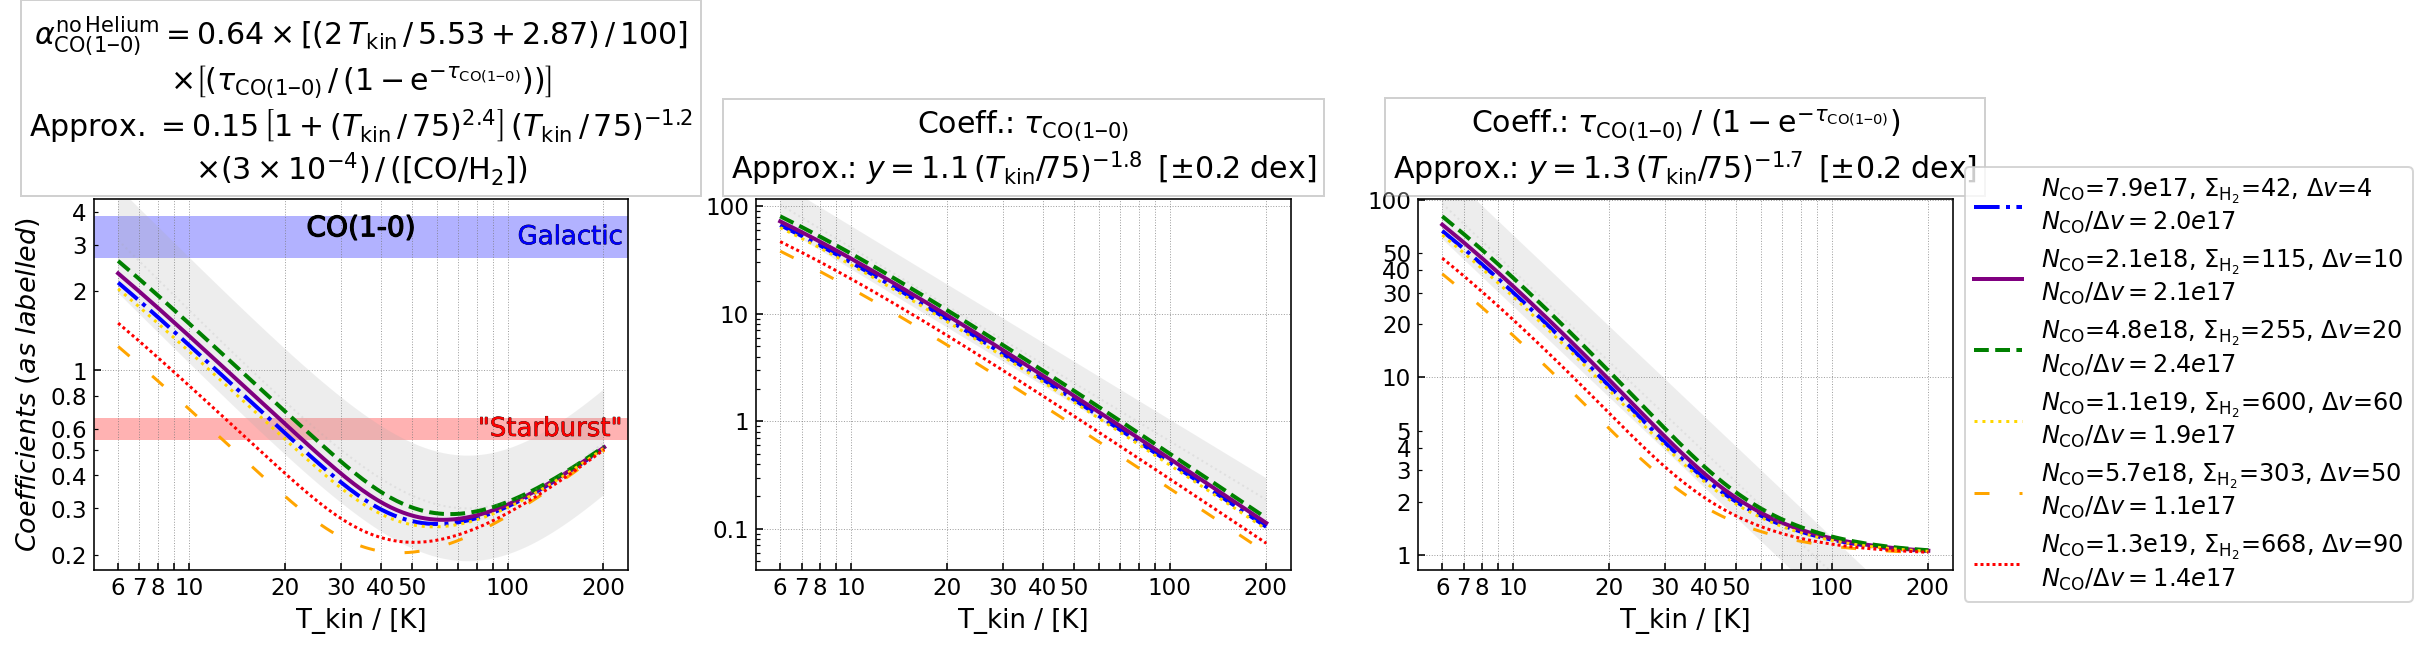

In [761]:
# tau CO10

z = 0. # 0. 4. 10.

top_left_text = 'CO(1-0)'

out_fig_name = 'Plot_LTE_tau_CO10'

first_panel_text = r'$\alpha_{\mathrm{CO(1{\tt{-}}0)}}^{\mathrm{no\,Helium}} = $' + \
                   r'$%.2f \times $'%(CO10_coe4.value) + \
                   r'$\left[ ( 2 \, T_{\mathrm{kin}} \, / \, 5.53 + %.2f ) \, / \, 100 \right]$'%(
                       CO10_kfactor) + \
                   '\n' + \
                   r'$\times \left[ ( \tau_{\mathrm{CO}(1{\tt{-}}0)} \, / \, ' + \
                   r'(1 - \mathrm{e}^{ - \tau_{\mathrm{CO}(1{\tt{-}}0)} }) ) \right]$'
                   # alphaCO10 function

CO10_to_H2_conversion = lambda tkin, tau: 0.64 * ( (2 * tkin / 5.53 + CO10_kfactor) / 100. ) \
                                               * ( tau / (1.0 - np.exp(-tau)) )

# x = np.array(global_list_of_T_kin) / 90.
# y = 0.18 * (1 + x**2.4) * x**(-1.2)
# testing = dict(x=x*90., y=y, 
#                label=r'Approx. $= 0.18 \, '
#                      r'\left[ 1 + (T_{\mathrm{kin}}/90)^{2.2} \right] \, (T_{\mathrm{kin}}/100)^{-1.2}$')

x = np.array(global_list_of_T_kin)
y = 0.15 * (1 + (x/75.)**2.4) * (x/75.)**(-1.2)
alphaCO10_function_dict = dict(x=x, y=y, 
                               label=r'Approx. $= 0.15 \, '
                                     r'\left[ 1 + (T_{\mathrm{kin}} \, / \, 75)^{2.4} \right] \, '
                                     r'(T_{\mathrm{kin}}\, / \, 75)^{-1.2}$'
                                     '\n'
                                     r'$\times (3 \times 10^{-4}) \, / \, (\mathrm{[CO/H_2]})$'
                              )


fig = make_a_plot_for_tau_term_vs_T_kin(
        z=z, 
        species='CO', 
        transition=0, 
        j_u=1, 
        species_to_H2_conversion=CO10_to_H2_conversion, 
        first_panel_text=first_panel_text, 
        first_panel_approx={#'x0':100, 'y0':0.3, 'slope':-1.2, 
                            #'testing': testing,
                            'function': alphaCO10_function_dict, 
                           },
        second_panel_approx={'x0':75, 'y0':1.1, 'slope':-1.8}, 
        third_panel_approx={'x0':75, 'y0':1.3, 'slope':-1.7}, 
        top_left_text=top_left_text, 
        out_fig_name=out_fig_name, 
    )

list_of_T_kin [  6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.
  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159.
 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173.
 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187.
 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 20

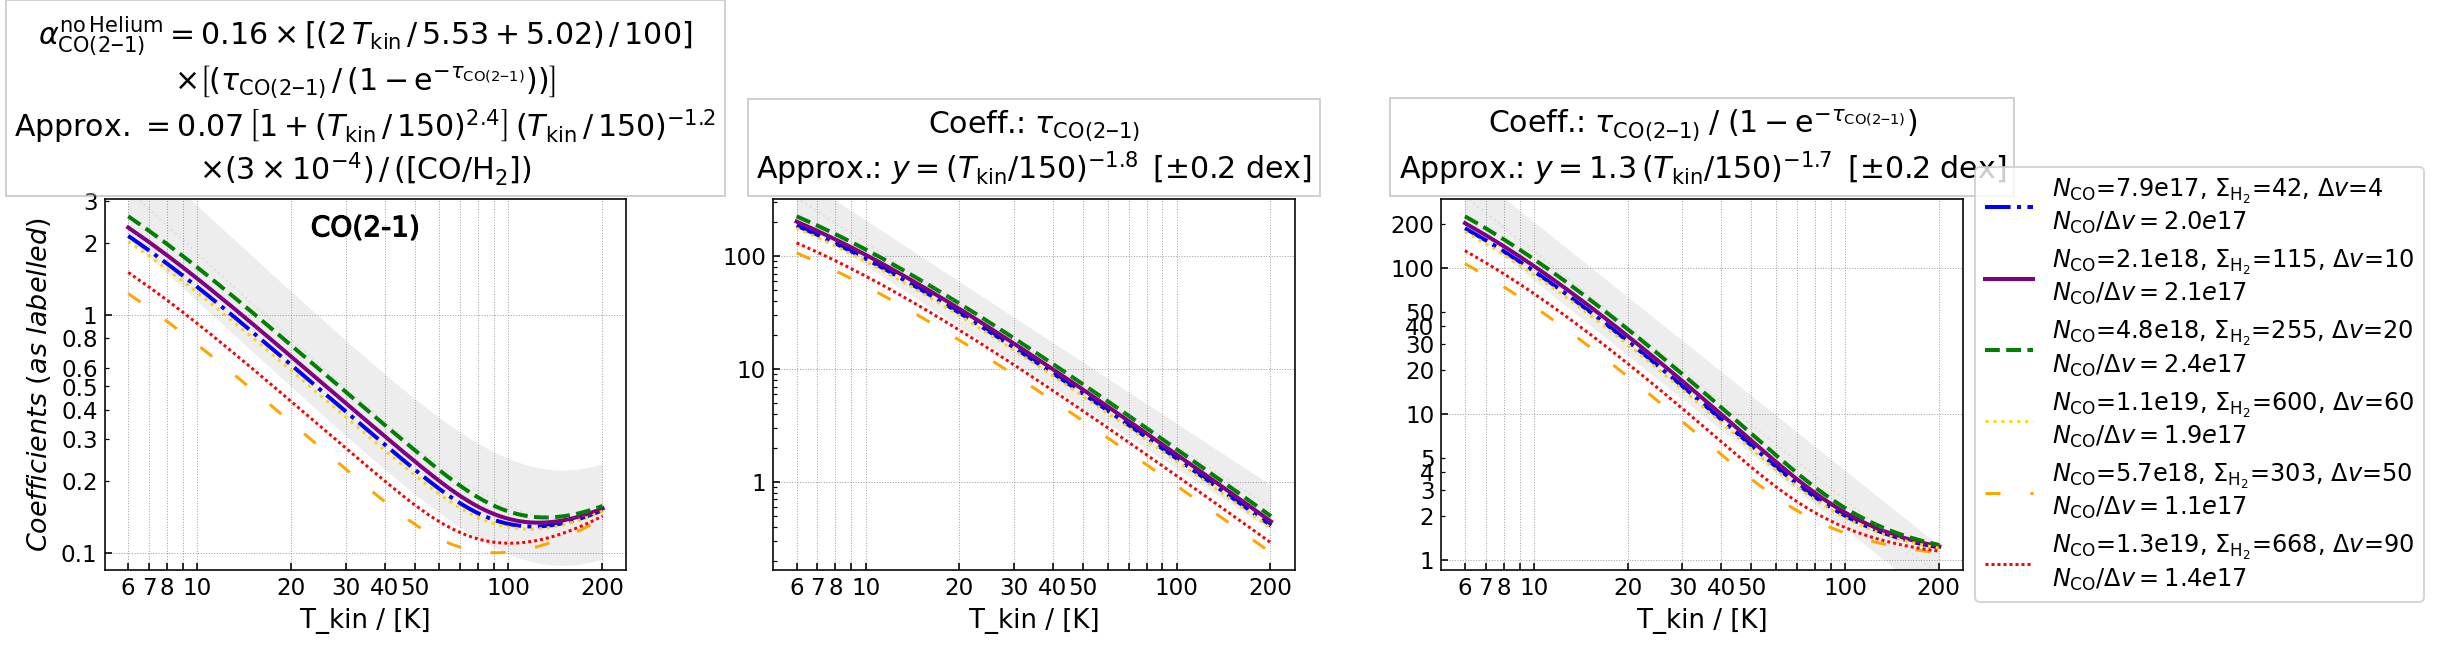

In [762]:
# tau CO21

z = 0. # 0. 4. 10.

top_left_text = 'CO(2-1)'

out_fig_name = 'Plot_LTE_tau_CO21'

first_panel_text = r'$\alpha_{\mathrm{CO(2{\tt{-}}1)}}^{\mathrm{no\,Helium}} = $' + \
                   r'$%.2f \times $'%(CO21_coe4.value) + \
                   r'$\left[ ( 2 \, T_{\mathrm{kin}} \, / \, 5.53 + %.2f ) \, / \, 100 \right]$'%(
                       CO21_kfactor) + \
                   '\n' + \
                   r'$\times \left[ ( \tau_{\mathrm{CO}(2{\tt{-}}1)} \, / \, ' + \
                   r'(1 - \mathrm{e}^{ - \tau_{\mathrm{CO}(2{\tt{-}}1)} }) ) \right]$'
                   # alphaCO21 function

CO21_to_H2_conversion = lambda tkin, tau: CO21_coe4.value * ( (2 * tkin / 5.53 + CO21_kfactor) / 100. ) \
                                                          * ( tau / (1.0 - np.exp(-tau)) )

x = np.array(global_list_of_T_kin)
y = 0.07 * (1 + (x/150.)**2.4) * (x/150.)**(-1.2)
alphaCO21_function_dict = dict(x=x, y=y, 
                               label=r'Approx. $= 0.07 \, '
                                     r'\left[ 1 + (T_{\mathrm{kin}} \, / \, 150)^{2.4} \right] \, '
                                     r'(T_{\mathrm{kin}}\, / \, 150)^{-1.2}$'
                                     '\n'
                                     r'$\times (3 \times 10^{-4}) \, / \, (\mathrm{[CO/H_2]})$'
                              )

fig = make_a_plot_for_tau_term_vs_T_kin(
        z=z, 
        species='CO', 
        transition=1, 
        j_u=2, 
        species_to_H2_conversion=CO21_to_H2_conversion, 
        first_panel_text=first_panel_text, 
        first_panel_approx={#'x0':100, 'y0':0.3, 'slope':-1.1,
                            'function': alphaCO21_function_dict, 
                           }, 
        second_panel_approx={'x0':150, 'y0':1.0, 'slope':-1.8}, 
        third_panel_approx={'x0':150, 'y0':1.3, 'slope':-1.7}, 
        top_left_text=top_left_text, 
        out_fig_name=out_fig_name, 
    )

list_of_T_kin [  6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.
  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159.
 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173.
 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187.
 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 20

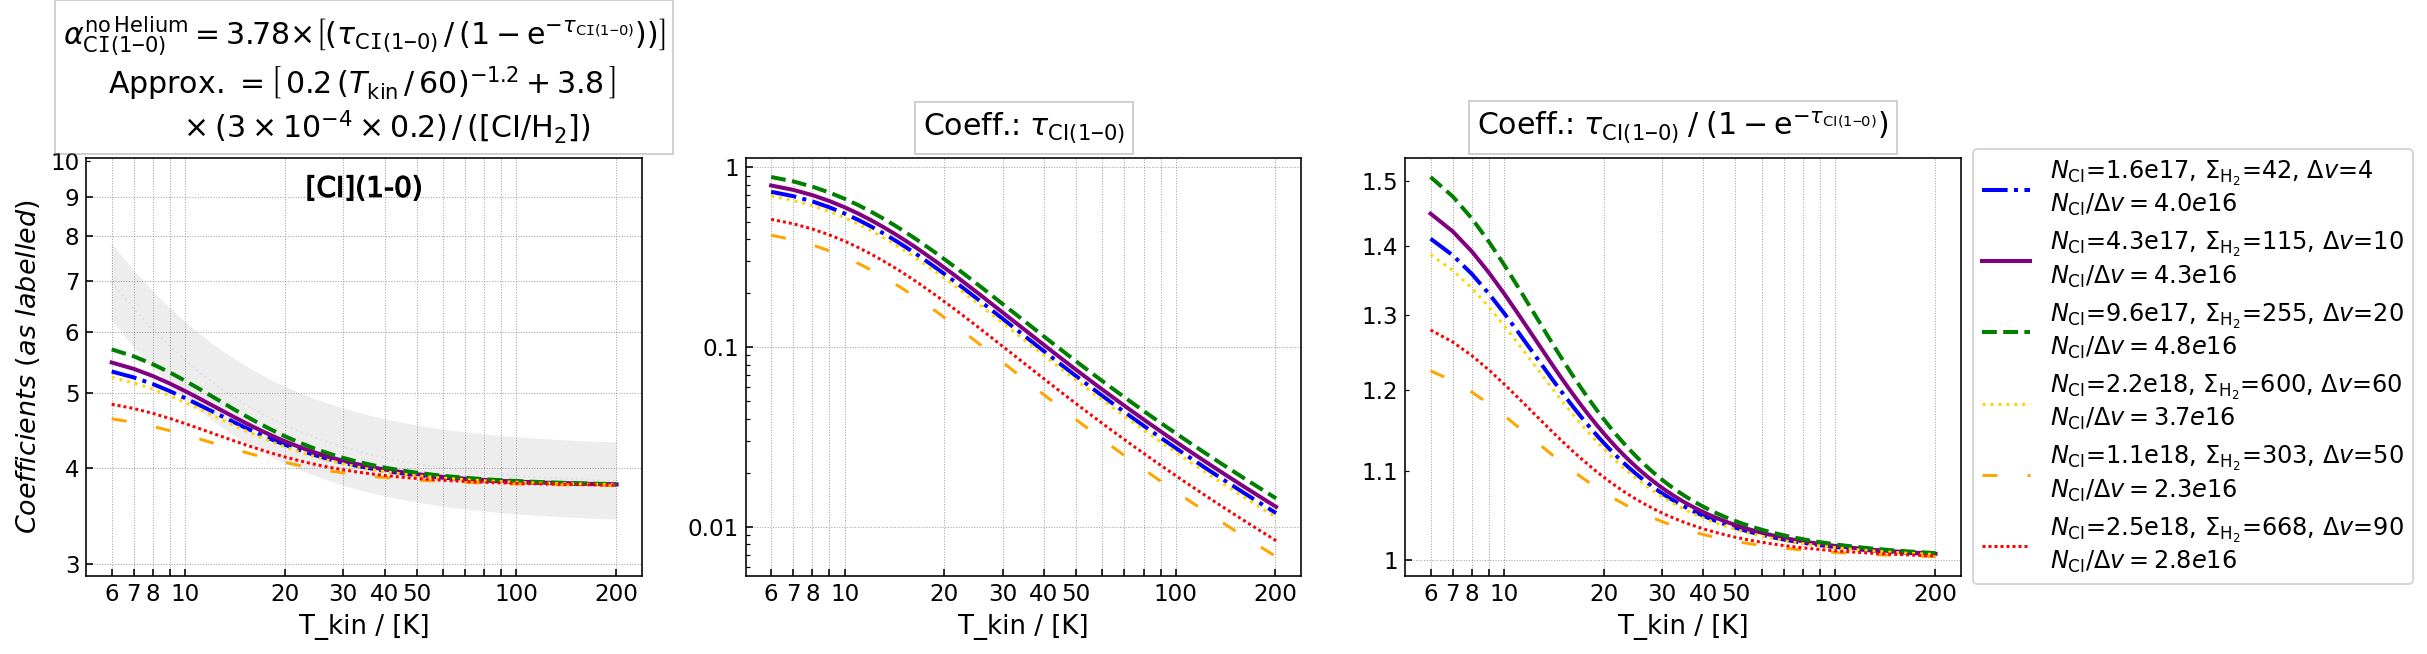

In [763]:
# tau CI10

z = 0. # 0. 4. 10.

top_left_text = '[CI](1-0)'

out_fig_name = 'Plot_LTE_tau_CI10'

first_panel_text = r'$\alpha_{\mathrm{C}{\tt{I}}(1{\tt{-}}0)}^{\mathrm{no\,Helium}} = $' + \
                   r'$%.2f$'%(CI10_coe4.value * CI10_kfactor) + \
                   r'$\times \left[ ( \tau_{\mathrm{C}{\tt{I}}(1{\tt{-}}0)} \, / \, ' + \
                   r'(1 - \mathrm{e}^{ - \tau_{\mathrm{C}{\tt{I}}(1{\tt{-}}0)} }) ) \right]$'
                   # alphaCI10 function coefficients

CI10_to_H2_conversion = lambda tkin, tau: CI10_coe4.value * CI10_kfactor * ( tau / (1.0 - np.exp(-tau)) )

x = np.array(global_list_of_T_kin)
y = 0.2 * (x/60.)**(-1.2) + 3.8
alphaCI10_function_dict = dict(x=x, y=y, dex=0.05, 
                               label=r'Approx. $= \left[ \, 0.2 \, '
                                     r'(T_{\mathrm{kin}} \, / \, 60)^{-1.2} + 3.8 \, \right] $ '
                                     '\n'
                                     r' $\quad \times (3 \times 10^{-4} \times 0.2) \, / \, (\mathrm{[CI/H_2]})$'
                                     #'\n'
                                     #r' $\quad [\pm 0.05 \, \mathrm{dex}]$'
                              )

fig = make_a_plot_for_tau_term_vs_T_kin(
        z=z, 
        species='CI', 
        transition=0, 
        j_u=1, 
        species_to_H2_conversion=CI10_to_H2_conversion, 
        first_panel_text=first_panel_text, 
        first_panel_approx={'function': alphaCI10_function_dict}, 
        top_left_text=top_left_text, 
        out_fig_name=out_fig_name, 
    )

list_of_T_kin [  6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.
  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159.
 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173.
 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187.
 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 20

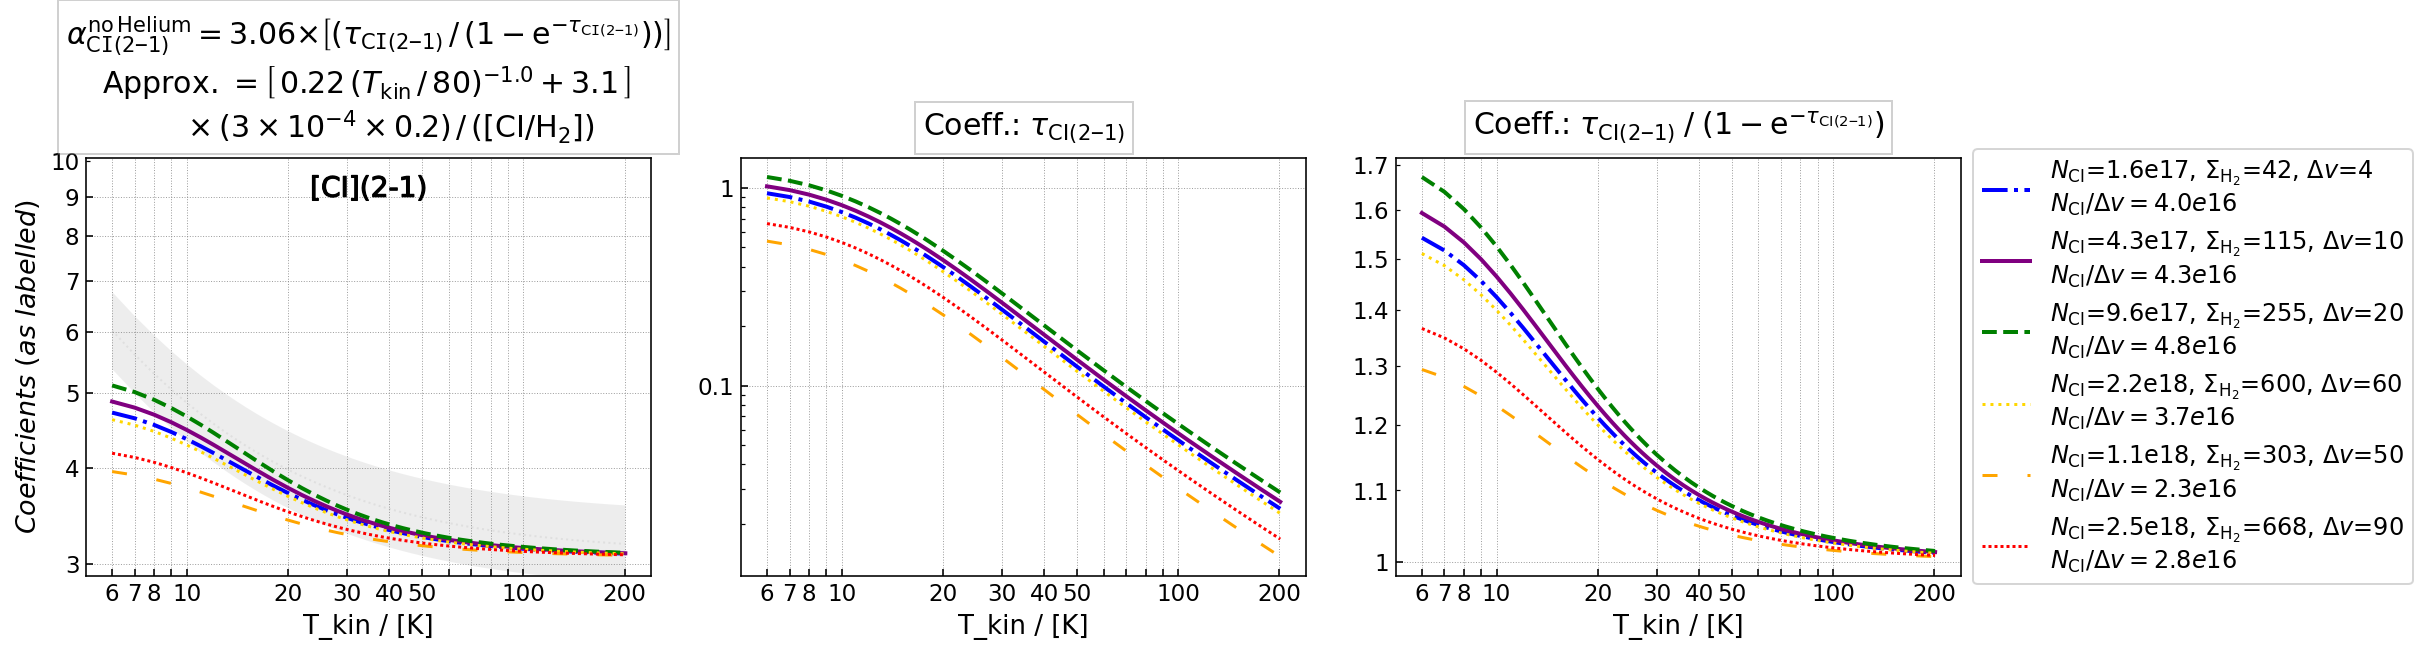

In [764]:
# tau CI21

z = 0. # 0. 4. 10.

top_left_text = '[CI](2-1)'

out_fig_name = 'Plot_LTE_tau_CI21'

first_panel_text = r'$\alpha_{\mathrm{C}{\tt{I}}(2{\tt{-}}1)}^{\mathrm{no\,Helium}} = $' + \
                   r'$%.2f$'%(CI21_coe4.value * CI21_kfactor) + \
                   r'$\times \left[ ( \tau_{\mathrm{C}{\tt{I}}(2{\tt{-}}1)} \, / \, ' + \
                   r'(1 - \mathrm{e}^{ - \tau_{\mathrm{C}{\tt{I}}(2{\tt{-}}1)} }) ) \right]$'
                   # alphaCI21 function coefficients

CI21_to_H2_conversion = lambda tkin, tau: CI21_coe4.value * CI21_kfactor * ( tau / (1.0 - np.exp(-tau)) )

x = np.array(global_list_of_T_kin)
y = 0.22 * (x/80.)**(-1.0) + 3.1
alphaCI21_function_dict = dict(x=x, y=y, dex=0.05, 
                               label=r'Approx. $= \left[ \, 0.22 \, '
                                     r'(T_{\mathrm{kin}} \, / \, 80)^{-1.0} + 3.1 \, \right] $ '
                                     '\n'
                                     r' $\quad \times (3 \times 10^{-4} \times 0.2) \, / \, (\mathrm{[CI/H_2]})$'
                                     #'\n'
                                     #r'$[\pm 0.05 \, \mathrm{dex}]$'
                              )

fig = make_a_plot_for_tau_term_vs_T_kin(
        z=z, 
        species='CI', 
        transition=1, 
        j_u=2, 
        species_to_H2_conversion=CI21_to_H2_conversion, 
        first_panel_text=first_panel_text, 
        first_panel_approx={'function': alphaCI21_function_dict}, 
        top_left_text=top_left_text, 
        out_fig_name=out_fig_name, 
    )